In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# enable outputs 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import files
# upload data_generator file
files.upload()


Saving data_generator.py to data_generator (1).py


{'data_generator.py': b'import random\nimport cv2\nimport numpy as np\n\nfrom imgaug import augmenters as iaa\nfrom tensorflow.keras import datasets\n\n\n(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()\n\n\ndef sometimes(aug): return iaa.Sometimes(0.5, aug)\n\n\nseq = iaa.Sequential([\n    iaa.Affine(\n        scale={"x": (0.8, 1), "y": (0.8, 1)},\n        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},\n        rotate=(-15, 15),\n        shear=(-5, 5),\n        cval=(0, 0),\n        mode=\'constant\'\n    )\n])\n\n\ndef crop_number(number):\n    """\n        Crops a MNIST digit to its containing bounding box with some random noise.\n    """\n    vsum = np.sum(number, axis=0)\n    vsum[vsum > 0] = 1\n    vdif = np.diff(vsum)\n    vdif[vdif > 0] = 1\n    xs = np.argwhere(vdif > 0).ravel()\n\n    random_cut1 = np.random.randint(-1, 3)\n    random_cut2 = np.random.randint(-1, 3)\n\n    try:\n        cropped_number = number[0:28, xs[0] - random_cut1:xs[1] + random

# Number classification

For our first task, we will build a **CNN** that will learn to identify which number appears in a image

## Data at hand
Our dataset was created by applying random transformations to digit images in MNIST database , concatenating them and afterwards padding the final image. 
The results consist of images of maximum three digit numbers, ranging from **0 to 255**. Each image is **28x84** and has 1 channel of colour, grayscale.

Our dataset is created on demand as explained above by two generator functions, *training_generator* and *test_generator*. These generator functions return a pair of images as described above, a pair of labels with the numbers in the images, and a label with the sum of these numbers.

## Input preprocessing

We create a wrapper for the given generator and unfold the pair of images and the pair of corresponding labels into an array of images and an array of labels. We will also normalize pixels by *dividing each of the pixel value by 255*.

## To generate or not to generate

Generators enable us to **train** and **evaluate** our model by not loading all data into memory. But this will increase fitting and testing times. 

This notebook ran in a *Google Colab* environment, that managed our workload well.  **60000  training samples**  and **6000 testing samples** were used.

In [0]:
# define generator wrapper and function to generate data based on a generator
from data_generator import training_generator, test_generator

# unpack array of pairs of images into an array
def seq_gen(generator, batch_size = 32):
  # a sample in generator will create pairs of two numbers.
  # So we halve the test size
  for batch in generator(batch_size // 2):
    x_new_batch = []
    y_new_batch = []
    x_batch , y_batch, sum_batch = batch
    for x_sample in x_batch:
      x_new_batch.append(x_sample[0])
      x_new_batch.append(x_sample[1])
    for y_sample in y_batch:
      y_new_batch.append(y_sample[0])
      y_new_batch.append(y_sample[1])
    yield (np.array(x_new_batch), np.array(y_new_batch), sum_batch)
 
#function to extract a batch from generator
def generate_data(generator):
  x_samples = []
  y_samples = []
  x_samples, y_samples, sum_samples = next(generator)
  x_samples = x_samples / 255.0
  x_samples = np.expand_dims(x_samples, -1)
  return x_samples, y_samples, sum_samples

    

In [157]:
%%time
train_size = 60000
test_size = 6000
seq_train_gen = seq_gen(training_generator, train_size)
X_train, Y_train, _ = generate_data(seq_train_gen)
seq_test_gen = seq_gen(test_generator, test_size)
X_test, Y_test, _ = generate_data(seq_train_gen)


CPU times: user 4min 30s, sys: 528 ms, total: 4min 31s
Wall time: 4min 31s


## Data Exploration
Take a look at how some of the images look like.

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'131')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'117')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'250')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'235')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'216')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'230')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'23')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'47')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'2')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'149')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'147')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'158')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'10')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'17')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'226')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'21')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'228')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'183')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'204')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'2')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'70')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'153')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'17')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'133')

([], <a list of 0 Text xticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

Text(0.5,0,'177')

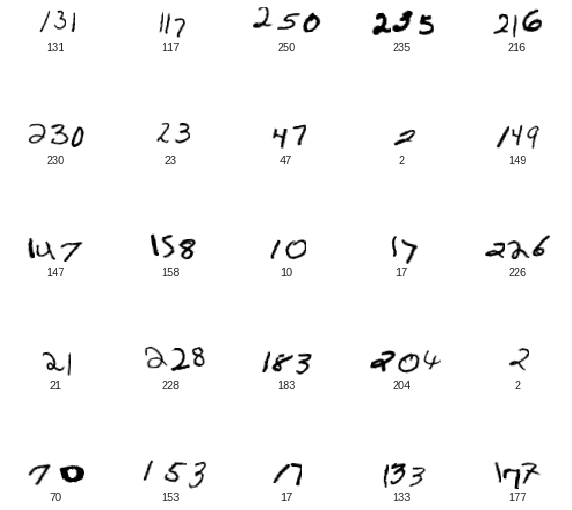

In [158]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.squeeze()[i], cmap=plt.cm.binary)
    plt.xlabel(Y_train[i])

For our model to work at its best, data should be **balanced**. So we check if all present labels have, with some approximation, the same number of occurences in our data.



Media aparitiilor : 235.29
Cea mai rar intalnita clasa apare de 189 ori
Cea mai des intalnita clasa apare de 293 ori.


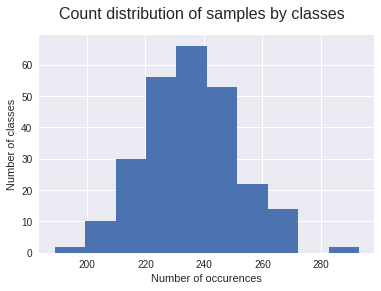

In [159]:
labels, counts = np.unique(Y_train, return_counts=True)
fig, ax = plt.subplots()
fig.suptitle('Count distribution of samples by classes', fontsize=16);
print('Media aparitiilor : %.2f' % (counts.mean()))
print('Cea mai rar intalnita clasa apare de %d ori' % (counts.min()))
print('Cea mai des intalnita clasa apare de %d ori.' % (counts.max()))
# ax.bar(labels, counts )
counts_p = counts / sum(counts)
ax.set_xlabel('Number of occurences');
ax.set_ylabel('Number of classes');
ax.hist(counts);

## Model Arhitecture

We use  **3 Convolutional layers** , followed by **MaxPooling** to train filters to extract relevant information from the image. 
Number of filters in the first layer is usually chosen smaller than at following layers because simpler features are usually extracted in the first layer : things like digit contours and shapes. 

We follow each of these with a **Dropout** layer of *0.4* dropout rate. We tried values ranging from 0.2 to 0.5 and model scores didn't vary much. 

We then **flatten** the output and add an additional  **Dense** layer of *128* neurons.

Finally, we get the network result by adding a **Dense** layer with **softmax**. The rest of the layers are activated using **relu**.

We tried **sgd**, **adam** and **rmsprop** as the optimizers of the problem. Even though *rmsprop* is usually used at rnn networks, it worked best here. The *sgd* trained slower than the others and *adam* gave comparable but smaller results than *rmsprop*.

In [160]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 84, 1)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation = 'softmax'))

model.summary()
# rmsprop pare cel mai bun, dar e recomandat pentru rnn-uri. 
# Mai încearca si cu adam si cu asta
# pentru input = 10000 (.3 split), cu 25 de epoci se ajunge la 75-80%
# pentru input = 60000 (.3 split), cu 5-10 epoci se ajunge la 70-80%
#rmsprop - 25 (27 val)
#sgd - 0.7
#adam - 26
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 26, 82, 32)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 41, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 13, 41, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 11, 39, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 19, 64)         0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 5, 19, 64)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 3, 17, 64)         36928     
__________

## Data preprocessing
Our labels are numbers ranging from 0 to 255. We will **one-hot encode** these labels to be compliant with the network arhitecture.

In [0]:
from keras.utils import to_categorical
Y_train_OH  = to_categorical(Y_train, num_classes=256)
Y_test_OH = to_categorical(Y_test, num_classes = 256)

For proper evaluation of the model and to avoid overfitting, we split train data into training and validation samples. We will fit our model on the train samples, but evaluate its performance after an epoch of training on the validation samples.

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train_OH, test_size = 0.3, random_state = 48)
x_test = X_test
y_test = Y_test_OH


## Fitting
We save the weights of the model with the best results on the validation set.

In [163]:
no_epochs = 30
# save best model in hdf5 file
checkpointer = keras.callbacks.ModelCheckpoint(filepath="numbers_2.hdf5", verbose=1, save_best_only=True)
history = model.fit(x_train, y_train, epochs=no_epochs, validation_data= (x_val, y_val) , callbacks=[checkpointer])

Train on 42000 samples, validate on 18000 samples
Epoch 1/30
41920/42000 [============================>.] - ETA: 0s - loss: 3.5271 - acc: 0.2211
Epoch 00001: val_loss improved from inf to 1.71302, saving model to numbers_2.hdf5
42000/42000 [==============================] - 30s 720us/step - loss: 3.5247 - acc: 0.2215 - val_loss: 1.7130 - val_acc: 0.5633
Epoch 2/30
41984/42000 [============================>.] - ETA: 0s - loss: 1.3470 - acc: 0.6588
Epoch 00002: val_loss improved from 1.71302 to 0.90095, saving model to numbers_2.hdf5
42000/42000 [==============================] - 15s 353us/step - loss: 1.3468 - acc: 0.6588 - val_loss: 0.9009 - val_acc: 0.7926
Epoch 3/30
41920/42000 [============================>.] - ETA: 0s - loss: 0.8941 - acc: 0.7839
Epoch 00003: val_loss improved from 0.90095 to 0.70320, saving model to numbers_2.hdf5
42000/42000 [==============================] - 15s 348us/step - loss: 0.8940 - acc: 0.7839 - val_loss: 0.7032 - val_acc: 0.8426
Epoch 4/30
41920/42000 [

### Plotting results

Define functions to plot training loss and validation loss of the training process. Do the same for training accuracy and validation accuracy.

In [0]:
def get_loss(history = history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']  
  return loss, val_loss

def get_acc(history = history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  return acc, val_acc

def get_epochs(no_epochs = no_epochs):
  epochs = range(1, no_epochs + 1)
  return epochs


def plot_loss(history = history, no_epochs = no_epochs):
  epochs = get_epochs(no_epochs)
  loss, val_loss = get_loss(history)
  plt.plot(epochs, loss, 'ko', label = 'Training Loss')
  plt.plot(epochs, val_loss, 'k', label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  
def plot_acc(history = history, no_epochs = no_epochs):
  epochs = get_epochs(no_epochs)
  acc, val_acc = get_acc(history)
  plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

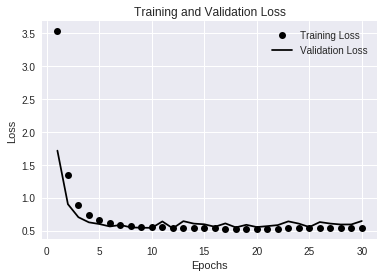

In [165]:
plot_loss()

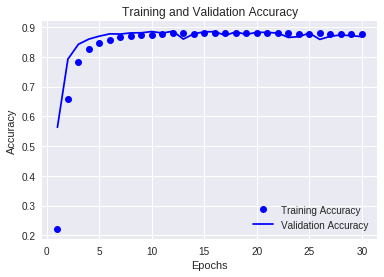

In [166]:
plot_acc()

### Score on test data

In [174]:
model = keras.models.load_model("numbers_2.hdf5")
model.evaluate(x_test,y_test)

60000/60000 [==============================] - 13s 208us/step


[0.5301458906372388, 0.88785]

### Plotting activations 

We plot activation of the some filters of some layers of the CNN.

In [0]:
from tensorflow.keras.models import Model

def get_activations(model, sample):
  layer_outputs = [layer.output for layer in model.layers]
  activation_model = Model(inputs=model.input, outputs=layer_outputs)
  activations = activation_model.predict(sample) #change the index for x_train[index] to use another image
  return activations
  

#when you call the function, col_size*row_size must be equal to the number of filters in that conv layer
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index] #act_index is the index of the layer eg. 0 is the first layer
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*5,col_size*5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

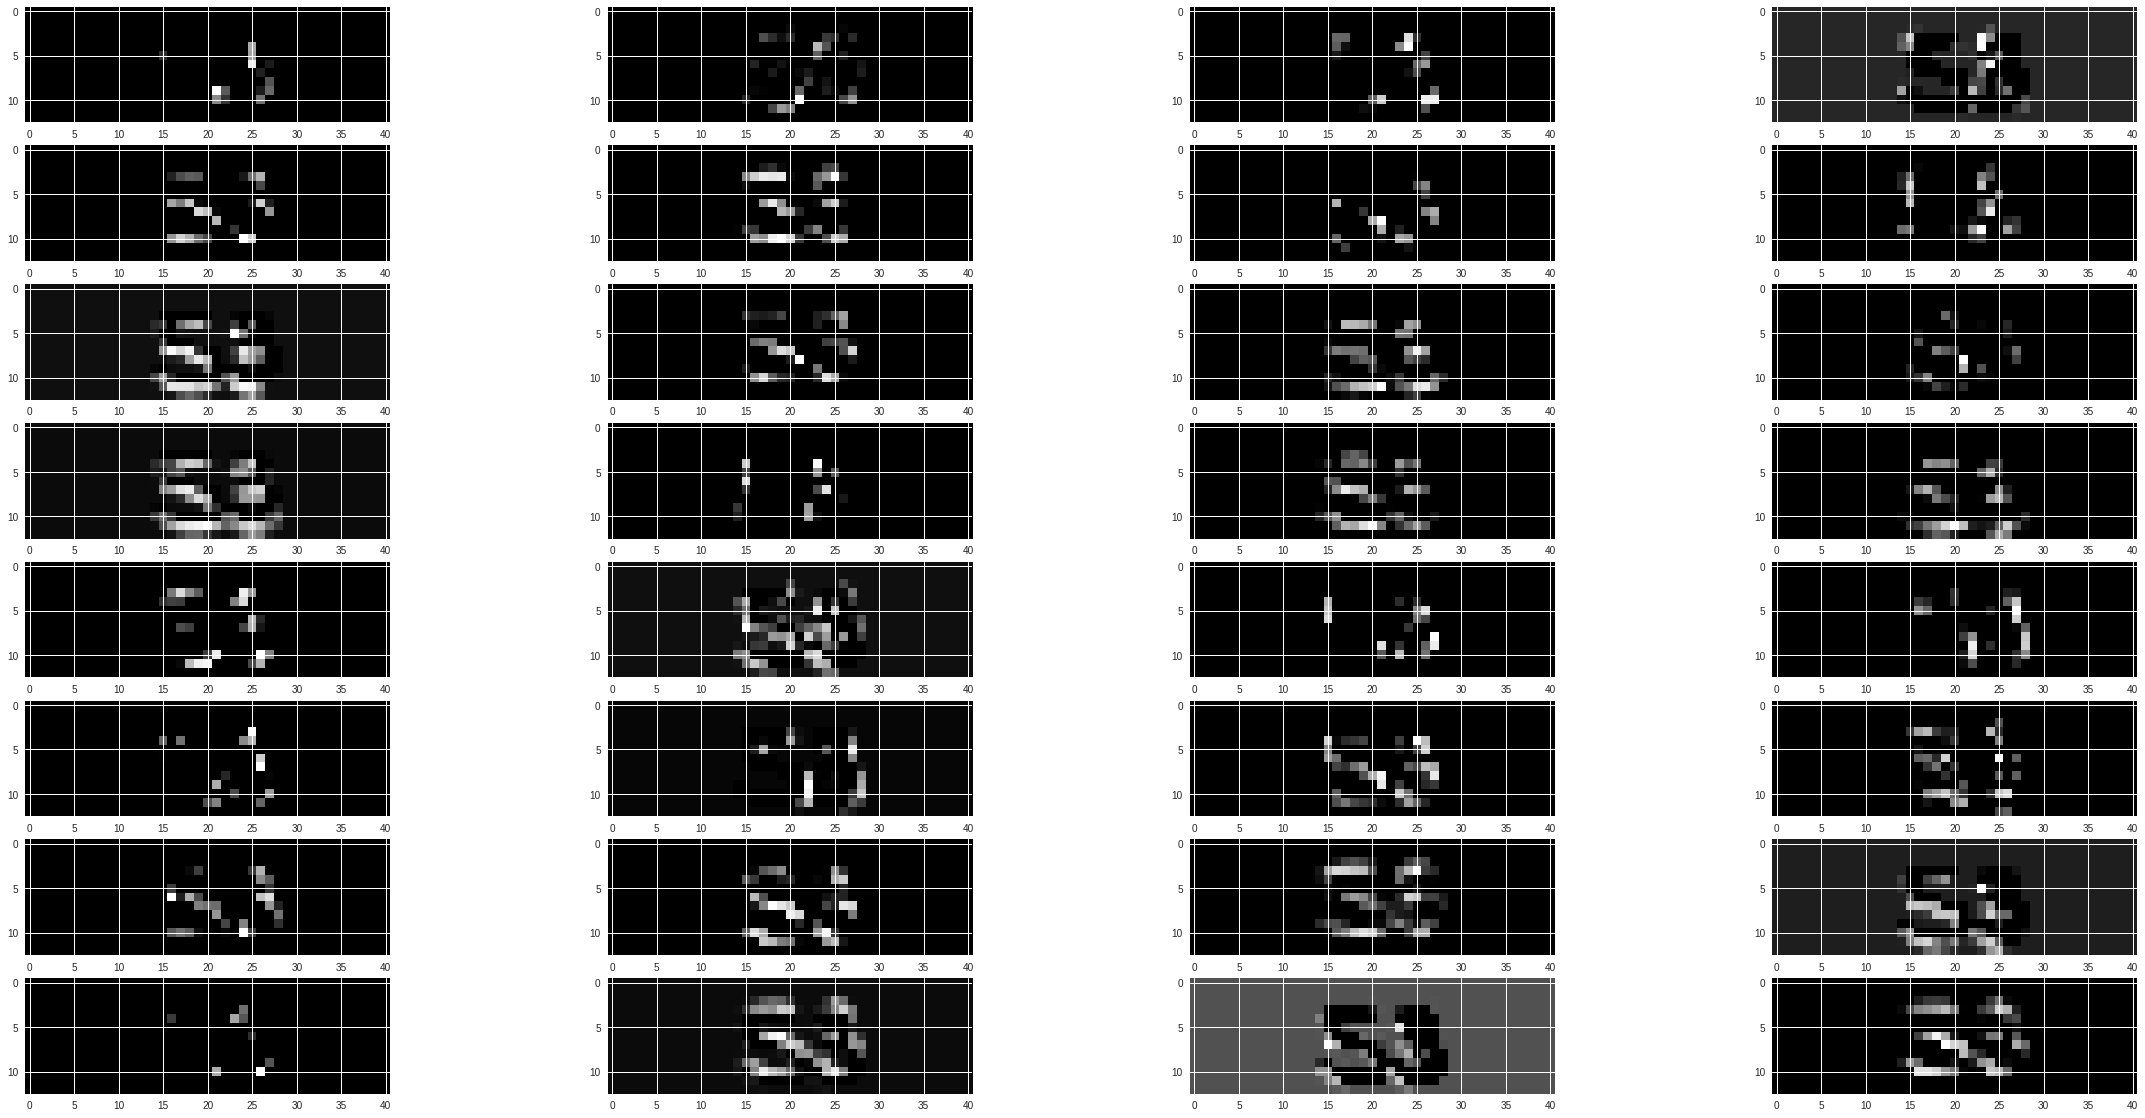

In [181]:
layer_to_inspect = 1
x = x_train[48].reshape(1,28, 84, 1)
activations = get_activations(model, x)
display_activation(activations, 4, 8, layer_to_inspect)

# Addition 

Given a pair of numbers, we will create an **RNN** that learns to output their sum. 
We will use the original generator function to generate data for this problem, but will also *normalize* the pixels. 

We will use **30 000 training samples** and **3 000 test samples**.


In [5]:
%%time
train_size = 30000
test_size = 3000
_, X_train, Y_train = generate_data(training_generator(train_size))
_, X_test, Y_test = generate_data(test_generator(test_size))

CPU times: user 2min 29s, sys: 2.13 s, total: 2min 31s
Wall time: 2min 31s


Obviously, we can define a simple MLP that does addition of two numbers. With a *Dense* layer of a **single neuron** with **weights set to 1** and **bias set to 0**, the network will perform addition of two input numbers.

But the problem at hand will be solved with an RNN, to illustrate training of reccurent neural networks.

In [6]:

# ADDITION MLP
adder = keras.models.Sequential()
adder.add(keras.layers.Flatten( input_shape = (2,)))
adder.add(keras.layers.Dense(1, weights = [np.array([[1], [1]]), np.array([0])]))
adder.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])

predictions = adder.predict(X_test)
correct_labels = np.sum(predictions == Y_test)
print('Accuracy of simple MLP : {}'.format( correct_labels / len(predictions) ))


Accuracy of simple MLP : 1.0


## Input / Output Preprocessing

To treat the problem as a **sequence-to-sequence** one, we will encode input and output as follow :

Each of the numbers will be converted to a padded string of three characters and the numbers will be concatenated afterwards. 
Output  will be a three character string representing the addition of the numbers.

```
Input : (23, 101) -> '023101' 
Output : '124' 
```
To feed this data into our model, we will **one-hot encode** each of the digits of the sequence and thus will obtain following input and output sizes : 

```
input.shape == (6,10)
output.shape == (3,10)


In [7]:
from keras.utils import to_categorical

def stringify_X(X):
  X_S = [''.join([str(number).zfill(3) for number in pair]) for pair in X.squeeze()]
  return X_S

def stringify_Y(Y):
  Y_S = [str(number).zfill(3) for number in Y.squeeze()]
  return Y_S
  
def onehot(arr):
  arr_split = np.array( [list(string) for string in arr])
  arr_OH = to_categorical(arr_split, num_classes = 10)
  return arr_OH

def encode_X(X):
  X_S = stringify_X(X)
  X_OH = onehot(X_S)
  return X_OH

def encode_Y(Y):
  Y_S = stringify_Y(Y)
  Y_OH = onehot(Y_S)
  return Y_OH

Using TensorFlow backend.


In [0]:
X_train_OH, Y_train_OH = encode_X(X_train), encode_Y(Y_train)
x_test, y_test = encode_X(X_test), encode_Y(Y_test)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train_OH, Y_train_OH, test_size = 0.3, random_state = 48)

## Model arhitecture

We will use a **encoder-decoder** arhitecture for the task at hand. 

First, we **encode** the input sequence using a **LSTM** of *128* units and will get an output of *128*.

The **decoder** will be another **LSTM** layer of *128* units. Output of the encoder will be repeatedly served to the decoder **3 times** using a **Repeat Vector** layer, because the maximum length of our addition output is 3 digits :
```
255 + 255 = 510
```
We then apply a **Dense** layer of *10 neurons* to every temporal slice of the input. This layer will decide which digit we keep for each of the step of the output sequence. 

To apply the above layer to every temporal slice, we wrap it in a **TimeDimensional** layer. Because it expects the first dimension of the input to be the timesteps, we must set **return_sequences** to *True* on the decoder layer. This makes the decoder output the whole output steps so far in the following form : 

```
output_so_far.shape == (num_samples, timesteps, output_dim)
```

We choose **rmsprop** as the optimizer of this problem because of its inclined advantage in *rnn arhitectures*.





In [10]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(6, 10)))
model.add(keras.layers.RepeatVector(3))
model.add(keras.layers.LSTM(128, return_sequences=True))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(10, activation='softmax')))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               71168     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 10)             1290      
Total params: 204,042
Trainable params: 204,042
Non-trainable params: 0
_________________________________________________________________


## Fitting

In [11]:
no_epochs = 30
checkpointer = keras.callbacks.ModelCheckpoint(filepath="add.hdf5", verbose=1, save_best_only=True)
history = model.fit(x_train, y_train, epochs = no_epochs, 
                    validation_data=(x_val, y_val), callbacks=[checkpointer])
model.evaluate(x_test, y_test)

Train on 21000 samples, validate on 9000 samples
Epoch 1/30
20960/21000 [============================>.] - ETA: 0s - loss: 1.9083 - acc: 0.2445
Epoch 00001: val_loss improved from inf to 1.89729, saving model to add.hdf5
21000/21000 [==============================] - 23s 1ms/step - loss: 1.9081 - acc: 0.2446 - val_loss: 1.8973 - val_acc: 0.2492
Epoch 2/30
20960/21000 [============================>.] - ETA: 0s - loss: 1.7519 - acc: 0.3138
Epoch 00002: val_loss improved from 1.89729 to 1.67201, saving model to add.hdf5
21000/21000 [==============================] - 22s 1ms/step - loss: 1.7517 - acc: 0.3139 - val_loss: 1.6720 - val_acc: 0.3483
Epoch 3/30
20960/21000 [============================>.] - ETA: 0s - loss: 1.5454 - acc: 0.4064
Epoch 00003: val_loss improved from 1.67201 to 1.55726, saving model to add.hdf5
21000/21000 [==============================] - 22s 1ms/step - loss: 1.5453 - acc: 0.4066 - val_loss: 1.5573 - val_acc: 0.3933
Epoch 4/30
20960/21000 [=========================

[0.0073602577500666184, 0.9978888867696126]

In [0]:
files.download("add.hdf5")

## Plotting
Plot accuracy and loss throughout training process, both on training and validation data

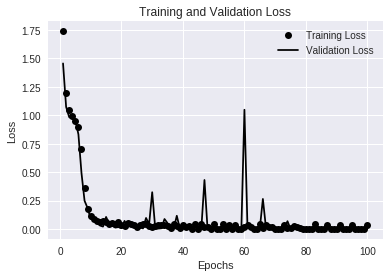

In [21]:
plot_loss()

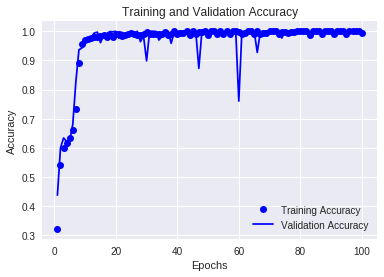

In [24]:
plot_acc()

## Evaluate the model

Because of the way our **LSTM** arhitecture works, it counts as its output each of the digits of the sequence. 
```
input = '023101'
output = '128'
real_output = '124'
accuracy = 2 / 3 (66%)
real_accuracy = 0 
```
Thus, if it correctly predicts two of three digits of a number, as above, it has *66%* accuracy, but its true accuracy on our problem is *0*, because it gave the wrong number. It esentially counts how many digits it got correctly, but we actually care how many numbers it got correctly.

To measure this, we will make predictions with our network and compare the predictions with the test data.


In [59]:
model = tf.keras.models.load_model("add.hdf5")
model.evaluate(x_test, y_test)

3000/3000 [==============================] - 4s 1ms/step


[0.0073602577500666184, 0.9978888867696126]

In [0]:
def true_accuracy(model, x_test, y_test):
  predicted = model.predict(x_test)
  predicted_OH = to_categorical(np.argmax(predicted, axis = 2), num_classes = 10)

  bool_test = np.all(predicted_OH == y_test, axis = (1,2))
  true_acc = np.sum(bool_test) / len(y_test)
  return true_acc


In [100]:
model = keras.models.load_model("add.hdf5")

true_acc = true_accuracy(model, x_test, y_test)
print('True accuracy : {}'.format(true_acc))

True accuracy : 0.9936666666666667


# End-to-End network

We train a network that receives a pair of images with numbers and outputs their sum.
We attempt to concatenate the above networks (referred below as **CNN** and **RNN**) in the following way :
1. Concatenate two images and add them as input to the *CNN*. 
```
input.shape == (28,168,1)
```
2. Remove the layer with **softmax**  from cnn and replace it with  a **reshape** layer. We reshape the output of the cnn and halve it to obtain pairs of parameters representing each image. 
```
cnn_output.shape == (128)
reshaped_output.shape == (2,64)
```
3. Run the obtained output through the **RNN**. 

In [29]:
%%time
train_size = 30000
test_size = 3000
train_gen = training_generator(train_size)
test_gen =  test_generator(test_size)
X_train, _ , Y_train = generate_data(train_gen)
X_test, _ , Y_test = generate_data(test_gen)

CPU times: user 2min 37s, sys: 1.99 s, total: 2min 39s
Wall time: 2min 39s


In [0]:
#concatenate images
X_train_CAT = np.array([np.hstack( (pair[0], pair[1])) for pair in X_train])
x_test = np.array([np.hstack( (pair[0], pair[1])) for pair in X_test])
Y_train_OH = encode_Y(Y_train)
# Y_train_OH = to_categorical(Y_train, num_classes=510)
y_test = encode_Y(Y_test)
# y_test = to_categorical(Y_test, num_classes=510)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train_CAT, Y_train_OH, test_size = 0.3, random_state = 48)

In [32]:
cnn = keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 168, 1)))
cnn.add(tf.keras.layers.MaxPooling2D(2, 2))
cnn.add(tf.keras.layers.Dropout(0.6))
cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(2, 2))
cnn.add(tf.keras.layers.Dropout(0.6))
cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(128, activation = 'relu'))
# cnn.add(tf.keras.layers.Dropout(0.5))

cnn.compile(optimizer = 'rmsprop',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

cnn.summary()


model = keras.models.Sequential()
model.add(cnn)

# lstm
model.add(tf.keras.layers.Reshape((2, 64)))
model.add(tf.keras.layers.LSTM(128, kernel_initializer = 'random_normal', recurrent_initializer = 'random_normal'))
model.add(tf.keras.layers.RepeatVector(3))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(keras.layers.Dense(10, activation='softmax')))

#convlstm
# model = keras.models.Sequential()
# model.add(tf.keras.layers.ConvLSTM2D(filters = 32, kernel_size = (3,3), activation = 'relu', 
#                                      padding = 'same', dropout = .2, input_shape = (28,168,1)))
# model.add(tf.keras.layers.RepeatVector(3))
# model.add(tf.keras.layers.ConvLSTM2D(filters = 32, kernel_size = (3,3), activation = 'relu', 
#                                      padding = 'same', dropout = .2 ))
# model.add(tf.keras.layers.TimeDistributed(keras.layers.Dense(10, activation='softmax')))



model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 166, 32)       320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 83, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 83, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 81, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 40, 64)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 40, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 38, 64)         36928     
__________

## Fitting

In [33]:
no_epochs = 30
checkpointer = keras.callbacks.ModelCheckpoint(filepath="end_to_end_2.hdf5", verbose=1, save_best_only=True)
history = model.fit(x_train, y_train, epochs = no_epochs, validation_data= (x_val, y_val), callbacks=[checkpointer])

Train on 21000 samples, validate on 9000 samples
Epoch 1/30
20960/21000 [============================>.] - ETA: 0s - loss: 1.9442 - acc: 0.2261
Epoch 00001: val_loss improved from inf to 1.90013, saving model to end_to_end_2.hdf5
21000/21000 [==============================] - 34s 2ms/step - loss: 1.9440 - acc: 0.2262 - val_loss: 1.9001 - val_acc: 0.2493
Epoch 2/30
20960/21000 [============================>.] - ETA: 0s - loss: 1.8657 - acc: 0.2561
Epoch 00002: val_loss improved from 1.90013 to 1.84230, saving model to end_to_end_2.hdf5
21000/21000 [==============================] - 28s 1ms/step - loss: 1.8657 - acc: 0.2561 - val_loss: 1.8423 - val_acc: 0.2686
Epoch 3/30
20960/21000 [============================>.] - ETA: 0s - loss: 1.8288 - acc: 0.2717
Epoch 00003: val_loss improved from 1.84230 to 1.81671, saving model to end_to_end_2.hdf5
21000/21000 [==============================] - 28s 1ms/step - loss: 1.8288 - acc: 0.2718 - val_loss: 1.8167 - val_acc: 0.2818
Epoch 4/30
20960/21000

## Plotting
We plot the loss and accuracy during training.
We observed that our validation set is actually helping us. 

The accuracy on training grows quickly, but the one on validation stays the same. It means that we are **overfitting**.

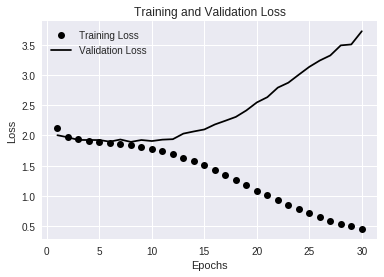

In [34]:
plot_loss()

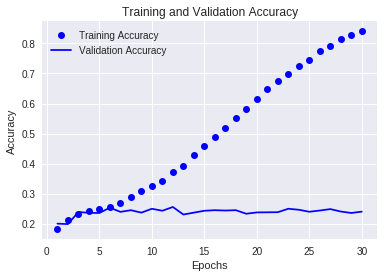

In [35]:
plot_acc()

## Evaluate the model

We evaluate the model below, both with the network accuracy and the true accuracy.

In [36]:
model = keras.models.load_model("end_to_end_2.hdf5")
model.evaluate(x_test, y_test)

3000/3000 [==============================] - 2s 828us/step


[1.6730531657536825, 0.35566666746139525]

In [37]:
model = keras.models.load_model("end_to_end_2.hdf5")
true_acc =true_accuracy(model,x_test,y_test)
print("True accuracy : {}".format(true_acc))

True accuracy : 0.018666666666666668


## Further improvements

We can add more dropout to prevent overfitting. Overfitting may also be caused by our model being too complex.
Also tried using **Convolutional LSTM** layers to apply the *RNN* directly on the image, but was stopped by some keras error. 